[ 3.85177739e-23 -4.74915586e-18  1.91904305e-13 -2.55841853e-09
 -3.02284863e-04  1.78019413e+01]


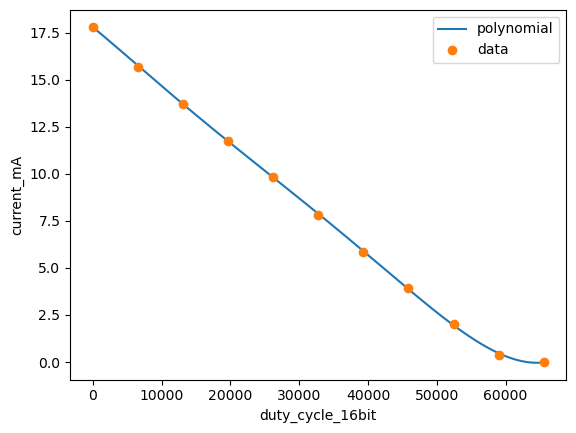

In [65]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root

# Raw data
duty_cycle_percent = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
duty_cycle_16bit = np.array([65535, 58982, 52428, 45875, 39321, 32768, 26214, 19661, 13107, 6554, 0])
current_mA = np.array([0, 0.393, 2.009, 3.912, 5.865, 7.834, 9.809, 11.770, 13.740, 15.700, 17.820])

# we find the n-th order polynomial that fits the data
n = 5
p = np.polyfit(duty_cycle_16bit, current_mA, n)
print(p)

# plot the polynomial
x = np.linspace(0, 65535, 1000)
y = np.polyval(p, x)
plt.plot(x, y, label='polynomial')
plt.plot(duty_cycle_16bit, current_mA, 'o', label='data')
plt.xlabel('duty_cycle_16bit')
plt.ylabel('current_mA')
plt.legend()
plt.show()

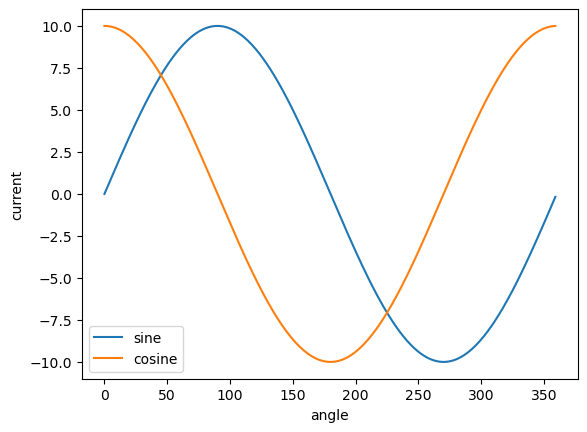

In [66]:
# each angel, has 2 currents associated with it, one for each coil (sine and cosine)
MaxCurrent = 10 # mA
Current = np.zeros((360, 2))
for i in range(360):
    Current[i][0] = MaxCurrent * np.sin(np.deg2rad(i))
    Current[i][1] = MaxCurrent * np.cos(np.deg2rad(i))

# plot the currents
plt.plot(Current[:, 0], label='sine')
plt.plot(Current[:, 1], label='cosine')
plt.xlabel('angle')
plt.ylabel('current')
plt.legend()
plt.show()

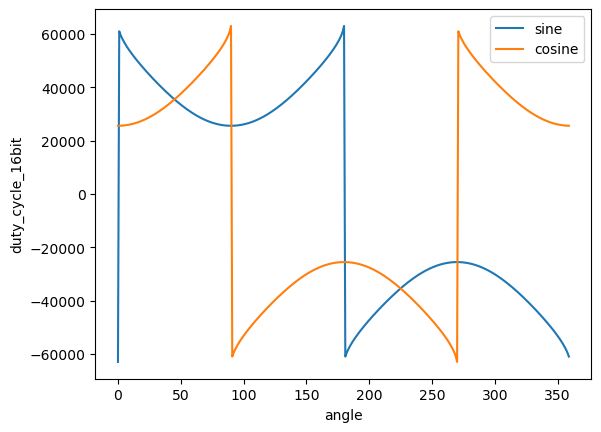

In [67]:
# initial guess for the duty cycle
# you might want to choose a more sensible initial guess
x0 = 0

# Now for each curent, we find the corosponding 16bit duty cycle (make it negative if it is negative)
duty_cycle_16bit = np.zeros((360, 2))
for i in range(360):
    for j in range(2):
        if Current[i][j] > 0:
            # define the function whose root we'll find
            func = lambda x: np.polyval(p, x) - Current[i][j]
            
            # find the root
            sol = root(func, x0)
            
            # ensure the solution has converged
            if sol.success:
                duty_cycle_16bit[i][j] = sol.x[0]
            else:
                print(f"Solution did not converge for i={i}, j={j}")
        else:
            # define the function whose root we'll find
            func = lambda x: np.polyval(p, x) + Current[i][j]
            
            # find the root
            sol = root(func, x0)
            
            # ensure the solution has converged
            if sol.success:
                duty_cycle_16bit[i][j] = - sol.x[0]
            else:
                print(f"Solution did not converge for i={i}, j={j}")

# plot the duty cycles
plt.plot(duty_cycle_16bit[:, 0], label='sine')
plt.plot(duty_cycle_16bit[:, 1], label='cosine')
plt.xlabel('angle')
plt.ylabel('duty_cycle_16bit')
plt.legend()
plt.show()

In [72]:
# now we print it a a C array on one line
print("const uint16_t duty_cycle_16bit[360][2] = {" , end='')
for i in range(360):
    print("{" + f"{int(duty_cycle_16bit[i][0])}, {int(duty_cycle_16bit[i][1])}" + "},", end='')
print("};")


const uint16_t duty_cycle_16bit[360][2] = {{-63034, 25566},{61023, 25571},{59723, 25587},{58657, 25613},{57717, 25649},{56861, 25696},{56063, 25753},{55311, 25821},{54593, 25899},{53903, 25987},{53238, 26086},{52592, 26195},{51963, 26314},{51349, 26443},{50748, 26583},{50159, 26732},{49580, 26892},{49010, 27062},{48450, 27241},{47896, 27430},{47351, 27630},{46812, 27838},{46279, 28057},{45752, 28285},{45231, 28522},{44716, 28769},{44206, 29025},{43700, 29290},{43200, 29564},{42705, 29847},{42215, 30139},{41729, 30440},{41249, 30748},{40773, 31066},{40302, 31391},{39836, 31725},{39375, 32066},{38919, 32415},{38468, 32772},{38023, 33136},{37582, 33507},{37148, 33886},{36719, 34271},{36295, 34663},{35878, 35062},{35467, 35467},{35062, 35878},{34663, 36295},{34271, 36719},{33886, 37148},{33507, 37582},{33136, 38023},{32772, 38468},{32415, 38919},{32066, 39375},{31725, 39836},{31391, 40302},{31066, 40773},{30748, 41249},{30440, 41729},{30139, 42215},{29847, 42705},{29564, 43200},{29290, 437